# Sea Ice Comparisons to Observations

This script shows how to load and plot sea ice concentration from CICE output and compare it to the NSIDC CDR (National Snow and Ice Data Centre, Climate Data Record) dataset

This notebook uses the _ACCESS-NRI Intake Catalog_ following the examples in [Tutorails/Using the Intake Catalog](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Using_Intake_Catalog.html). 

Requirements: The runs analysed here are only in access-nri-intake-catalog version 0.1.0 or newer. This is included in `conda/analysis3-23.10` or newer modules from `/g/data/hh5/public/modules`. 

**OM2 Expreiments:**

These are the ACCESS-OM2 runs we are going to use, we can compare results from prototype runs forced with ERA5 against normal runs using JRA55do, as [described on the ACCESS_HIVE](https://forum.access-hive.org.au/t/era-5-forced-access-om2-simulations/1103/5). To compare against the observational datasets, we use IAF (Inter-Annual Forcing).

In [1]:
RUNS={
    '025deg_era5':['025deg_era5_iaf'], #(our name: run name(s))
    '025deg_jra55': ['025deg_jra55_iaf_era5comparison'],
    '1deg_era5':['1deg_era5_iaf'],
    '1deg_jra55':['1deg_jra55_iaf_era5comparison']
}

We are going to look at Sea Ice Concentration

In [2]:
VARS=['aice_m'] # ice area fraction or sea ice concentration
VARS_2D=['area_t','geolat_t','geolon_t']

**Observational Data:**

Sea Ice concentration is measured through passice microwave remote sensing. We are going to used the NSIDC CDR Dataset (descibed at [nsidc.org](https://nsidc.org/data/g02202/versions/4))

In [3]:
ST='1979' #start date
ET='2022' #end date
OBS_TIME_SLICE=slice(ST,ET)
sh_obs_url='https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday'
nh_obs_url='https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday'

Load packages:

In [6]:
from intake import cat
from datatree import DataTree,map_over_subtree

from dask.distributed import Client

import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf

#plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines

Start a dask client

In [7]:
client = Client()

In [8]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45613,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:43581,Total threads: 3
Dashboard: /proxy/34869/status,Memory: 11.50 GiB
Nanny: tcp://127.0.0.1:33579,


Open the catalog

In [9]:
catalog = cat.access_nri

# Load the ACCESS-OM2 results

For CICE data in OM2, we need to do some wrangling to make it easier to deal with. This is described in more detail in [DocumentedExamples/SeaIce_Plot_Example](https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/SeaIce_Plot_Example.html). Its included in this function:

In [10]:
def open_by_experiment(exp_name, vars):
    """ Concatenate any datasets provided for this experiment into one ds, and add area and geo coordinates """

    import xarray as xr
    import cf_xarray as cfxr
    
    open_by_name = lambda name : catalog[name].search(
        variable=vars
    ).to_dask(
        xarray_open_kwargs={"chunks":{'time':'auto','ni':-1,'nj':-1},"decode_coords":False},
        xarray_combine_by_coords_kwargs={'compat':'override','data_vars':'minimal', 'coords':'minimal'}
    )

    #get the data for each run of this config 
    cice_ds=xr.concat([
        open_by_name(iName) for iName in RUNS[exp_name]
    ], dim='time'
    )
    
    #We also want the area/lat/lom fields, but these are not time dependent.
    area_ds=xr.merge([
        xr.open_dataset(
            catalog[RUNS[exp_name][0]].search(variable=iVar).df.path[0] 
            # path of the first file with the area field, the geolon field and the geolat field 
        ).drop('time')
    for iVar in VARS_2D])

    #Label the lats and lons
    cice_ds.coords['ni'] = area_ds['xt_ocean'].values
    cice_ds.coords['nj'] = area_ds['yt_ocean'].values
    
    #Copy attributes for cf compliance
    cice_ds.ni.attrs=area_ds.xt_ocean.attrs
    cice_ds.nj.attrs=area_ds.yt_ocean.attrs
    
    cice_ds = cice_ds.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    
    # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
    
    cice_ds=cice_ds.assign_coords({
        'geolat_t':area_ds.geolat_t,
        'geolon_t':area_ds.geolon_t,
        'area_t':area_ds.area_t
    })

    #cice timestamps are also misleading:
    cice_ds['time'] = cice_ds.time.to_pandas() - timedelta(days = 1)
       
    return cice_ds

Because the dimensions are different for different experiments, they would not fit in a Dataset, a DataTree is required. The DataTree has a group for each experiment, which contains a xarray dataset with the data for that experiment. 

In [11]:
%%time

si_name_ds_pairs = [(iRun, open_by_experiment(iRun, VARS)) for iRun in RUNS.keys()]

si_dt = DataTree.from_dict(
    dict(si_name_ds_pairs)
)

0.3.0
CPU times: user 46.2 s, sys: 6.47 s, total: 52.7 s
Wall time: 4min 11s


In [12]:
@map_over_subtree
def match_timestamps_to_NSIDC(ds):

    cice_ds = ds.copy()

    # we are going to use the same timestamps as NSIDC
    cice_ds['time'] = [np.datetime64(str(i)[0:7]+'-01T00:00:00.000000000') for i in cice_ds.time.values]

    return cice_ds

In [13]:
si_dt = match_timestamps_to_NSIDC(si_dt)

The result is a datatree, with a dataset for each experiment and timestamps which align with the observational timestamps

In [14]:
si_dt

DataTree('None', parent=None)
├── DataTree('025deg_era5')
│       Dimensions:   (time: 523, yt_ocean: 1080, xt_ocean: 1440)
│       Coordinates:
│         * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
│         * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
│         * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
│           geolat_t  (yt_ocean, xt_ocean) float32 ...
│           geolon_t  (yt_ocean, xt_ocean) float32 ...
│           area_t    (yt_ocean, xt_ocean) float32 ...
│       Data variables:
│           aice_m    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│       Attributes: (12/18)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
│           intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,time: mean,ti...
│           intake_esm_attrs:variable_units:          days since 1980-01-01 00:00:00,...
│           intake_esm_attrs:file_id:                 iceh_XXXX_XX
│           intake_esm_attrs:_data_format_:           netcdf
│           intake_esm_dataset_key:                   iceh_XXXX_XX.1mon
├── DataTree('025deg_jra55')
│       Dimensions:   (time: 523, yt_ocean: 1080, xt_ocean: 1440)
│       Coordinates:
│         * time      (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2023-07-01
│         * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
│         * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
│           geolat_t  (yt_ocean, xt_ocean) float32 ...
│           geolon_t  (yt_ocean, xt_ocean) float32 ...
│           area_t    (yt_ocean, xt_ocean) float32 ...
│       Data variables:
│           aice_m    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
│       Attributes: (12/18)
│           title:                                    sea ice model output for CICE
│           contents:                                 Diagnostic and Prognostic Varia...
│           source:                                   Los Alamos Sea Ice Model (CICE)...
│           time_period_freq:                         month_1
│           comment3:                                 seconds elapsed into model date...
│           conventions:                              CF-1.0
│           ...                                       ...
│           intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
│           intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,time: mean,ti...
│           intake_esm_attrs:variable_units:          days since 1980-01-01 00:00:00,...
│           intake_esm_attrs:file_id:                 iceh_XXXX_XX
│           intake_esm_attrs:_data_format_:           netcdf
│           intake_esm_dataset_key:                   iceh_XXXX_XX.1mon
├── DataTree('1deg_era5')
│       Dimensions:   (time: 708, yt_ocean: 300, xt_ocean: 360)
│       Coordinates:
│         * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
│         * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
│         * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
│           geolat_t  (yt_ocean, xt_ocean) float32 ...
│           geolon_t  (yt_ocean, xt_ocean) float32 ...
│           area_t    (yt_ocean, xt_ocean) float32 ...
│       Data variables:
│           aice_m    (time, yt_

# Load the observational dataset

In [15]:
def open_cdr_dataset(path, area_file):
    ds=xr.open_dataset(path).rename(
        {'cdr_seaice_conc_monthly':'cdr_seaice_conc','xgrid':'x','ygrid':'y'}
    )#.swap_dims({'tdim':'time','x':'xgrid','y':'ygrid'})

    #we also need the area of each gridcell
    datFile=open(area_file, 'rb')
    #pss25area_v3.dat: 316 columns x 332 rows
    areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape(ds.cdr_seaice_conc.isel(time=0).shape)
    #Divide by 1000 to get km2
    areasKmNd_sh=areasDmNd/1000

    ds['area']=xr.DataArray(areasKmNd_sh, dims=['y','x'])
    ds=ds.set_coords('area')

    ds=ds.cdr_seaice_conc
    
    ds=ds.where(ds<=1) #convert error codes to Nan

    return ds

We can pull the datasets direct from the url, however the cell area needs to be downloaded seperately:

In [16]:
!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat 

File ‘pss25area_v3.dat’ already there; not retrieving.
File ‘psn25area_v3.dat’ already there; not retrieving.


In [17]:
sh_cdr_xr = open_cdr_dataset(
    sh_obs_url,
    'pss25area_v3.dat'
)

# nh_cdr_xr = open_cdr_dataset(
#     nh_obs_url,
#     'psn25area_v3.dat'
# )

cdr_dt = DataTree.from_dict({
    'cdr_sh':sh_cdr_xr,
    # 'cdr_nh':nh_cdr_xr
})

The result is a datatree, with seperate datasets for each hemisphere

# Calculate Sea Ice Area

Sea ice area is the circumpolar sum of sea ice concentration multiplied by the area of each grid cell. By convention, and because lower concentrations are not accurate when measured through remote sensing, concentrations below 0.15 are not included

In [18]:
def sea_ice_area(sic,area, range=[0.15,1]):
    return (sic*area).where((sic>=range[0])*(sic<=range[1])).cf.sum(['X','Y'])

Calculate for observational data, and remove gaps with missing data

In [19]:
@map_over_subtree
def sea_ice_area_obs(ds):
    sic=ds.cdr_seaice_conc
    result=sea_ice_area(sic,sic.area).to_dataset(name='cdr_area')

    #Theres a couple of data gaps which should be nan
    result.loc[{'time':'1988-01-01'}]=np.nan
    result.loc[{'time':'1987-12'}]=np.nan

    return result.sel(time=OBS_TIME_SLICE)

In [20]:
obs_area_dt=sea_ice_area_obs(cdr_dt)

In [21]:
#Theres another gap which should be nan
#obs_area_dt['cdr_nh'].to_dataset().loc[{'time':'1984-07'}]=np.nan

Calculate for model data, limit to southern hemisphere / Antarctica

In [22]:
@map_over_subtree
def sea_ice_area_model_sh(ds):
    sic=ds.aice_m.cf.sel(Y=slice(-90,0))   
    area_km2=ds.area_t/1e6

    return sea_ice_area(sic,area_km2).to_dataset(name='si_area').load()

In [23]:
model_area_dt=sea_ice_area_model_sh(si_dt)

# Sea Ice Area Trends

We are going to compare the trends in the minima and maxima over time, and the climatology

In [24]:
@map_over_subtree
def min_and_max(ds):
    def min_and_max_year(da):
        result = xr.Dataset()
        result['min']=da.min()
        result['max']=da.max()
        return result
    annual_min_max_ds=ds.si_area.groupby('time.year').apply(min_and_max_year)
    return annual_min_max_ds
    
model_min_max_dt=min_and_max(model_area_dt)

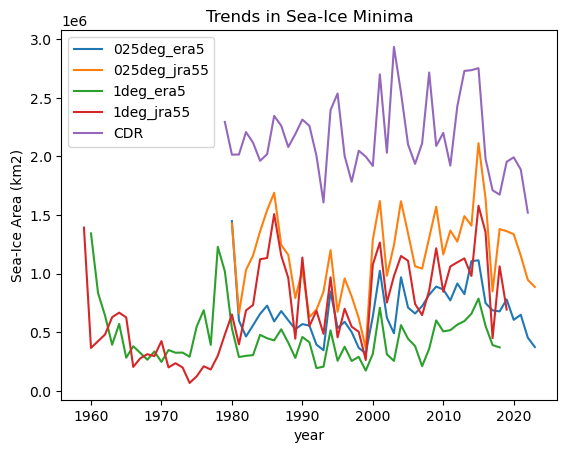

In [25]:
for iGroup in model_min_max_dt.groups[1:]:
    ds=model_min_max_dt[iGroup].ds
    ds['min'].plot(label=iGroup[1:])

obs_area_dt['cdr_sh'].ds.cdr_area.groupby('time.year').min().plot(label='CDR')

plt.title('Trends in Sea-Ice Minima')
plt.ylabel('Sea-Ice Area (km2)')

_ = plt.legend()

We see that all models have sea ice area which is too low in summer. Model runs forced by JRA have more variability than those forced by ERA5 and are slightly closer to the measured sea ice area from observations.

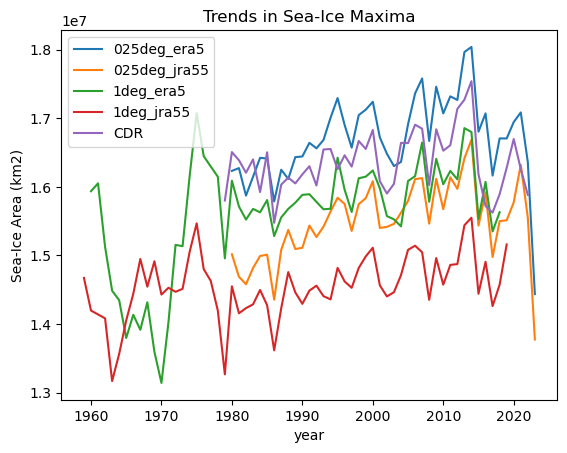

In [26]:
for iGroup in model_min_max_dt.groups[1:]:
    ds=model_min_max_dt[iGroup].ds
    ds['max'].plot(label=iGroup[1:])

obs_area_dt['cdr_sh'].ds.cdr_area.groupby('time.year').max().plot(label='CDR')

plt.title('Trends in Sea-Ice Maxima')
plt.ylabel('Sea-Ice Area (km2)')

_ = plt.legend()

We see that the closest runs are those forced by ERA5, and the runs forced by JRA55 are under representing Winter sea ice.

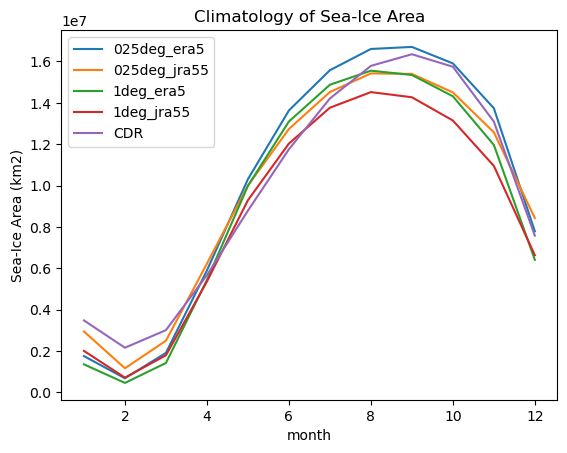

In [27]:
for iGroup in model_area_dt.groups[1:]:
    model_area_dt[iGroup].ds.si_area.groupby('time.month').mean('time').plot(label=iGroup[1:])

obs_area_dt['cdr_sh'].ds.cdr_area.groupby('time.month').mean('time').plot(label='CDR')

plt.title('Climatology of Sea-Ice Area')
plt.ylabel('Sea-Ice Area (km2)')

plt.legend()

We see all model runs have too low sea ice in summer, and grow faster than observations in autumn and earlier that the observed maximum.

# Sea Ice Area differences

To examine the differences between the model results and observations, we calculate difference in each grid cell between observations and each experiment

As that data are on different grids, we need to regrid to compare the datasets

Lets simplify a little to only look at 0.25

In [28]:
groups=('/025deg_era5', '/025deg_jra55')

In [29]:
cdr_dt['cdr_sh']

DataTree('cdr_sh', parent="None")
    Dimensions:          (time: 536, y: 332, x: 316)
    Coordinates:
      * time             (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2023-06-01
      * y                (y) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
      * x                (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
        area             (y, x) float64 444.1 445.0 445.9 ... 462.1 461.1 460.1
    Data variables:
        cdr_seaice_conc  (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

The lat/lon of of each cell in the observational dataset are in a different file:

In [30]:
! wget -nc https://noaadata.apps.nsidc.org/NOAA/G02202_V4/ancillary/G02202-cdr-ancillary-sh.nc

File ‘G02202-cdr-ancillary-sh.nc’ already there; not retrieving.



In [31]:
cdr_sps_ds=xr.open_dataset('G02202-cdr-ancillary-sh.nc')

We can now build the re-gridder. This is described in detail in [DocumentedExamples/Regridding](https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/Regridding.html)

In [32]:
regridder_ACCESSOM2_025deg_sh = xesmf.Regridder(
    si_dt['025deg_era5'].ds.isel(time=0).drop(['xt_ocean','yt_ocean']), 
    cdr_sps_ds, 
    'bilinear', 
    periodic=True,
    unmapped_to_nan=True
)

In [33]:
aice_sh_3976_ds=xr.Dataset()
aice_sh_diff_ds=xr.Dataset()

for iG in groups:
    aice_sh_3976_ds[iG]=regridder_ACCESSOM2_025deg_sh(
        si_dt[iG].ds.aice_m
    ).load()
    aice_sh_diff_ds[iG]=aice_sh_3976_ds[iG]-cdr_dt['cdr_sh'].ds.cdr_seaice_conc.load()

We can now plot the difference between modelled and observed sea ice concentration

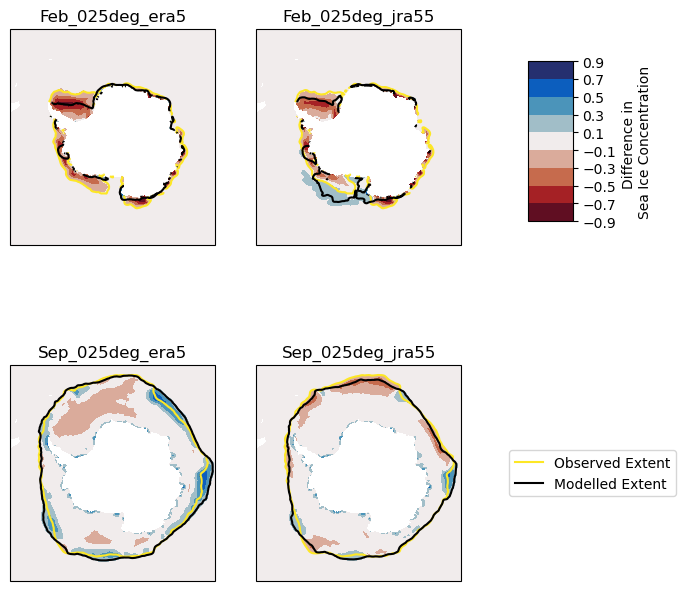

In [35]:
months=[2,9] #february, september
month_names=['Feb','Sep']
n_months=len(months)

plt.figure(figsize=(9,n_months*4))
j=0

cdr=cdr_dt['cdr_sh'].ds.cdr_seaice_conc

for iMonth in np.arange(0,n_months):

    i=1

    for iGroup in aice_sh_diff_ds.data_vars:
        ds=aice_sh_diff_ds[iGroup]
        
        ds=ds.sel(time=ds.time.dt.month.isin(months[iMonth])).mean('time')
        
        ax = plt.subplot(n_months,3,i+j*3,projection=ccrs.SouthPolarStereo(true_scale_latitude=-70))
            
        plt.contourf(
            ds.x, ds.y, ds,
            levels=np.arange(-0.9,0.91,.2), cmap=cmo.balance_r
        )

        cs_cdr=cdr.sel(time=cdr.time.dt.month.isin(months[iMonth])).mean('time').plot.contour(levels=[0.15])
        
        da=aice_sh_3976_ds[iGroup]
        cs_mod=da.sel(time=da.time.dt.month.isin(months[iMonth])).mean('time').plot.contour(levels=[0.15], colors=['black'])

        plt.title(month_names[iMonth]+'_'+iGroup[1:])
        i+=1

    j+=1


color_cdr = cs_cdr.collections[0].get_edgecolor()
line_cdr = mlines.Line2D([], [], color=color_cdr, label="Observed Extent")

color_mod = cs_mod.collections[0].get_edgecolor()
line_mod = mlines.Line2D([], [], color=color_mod, label="Modelled Extent")

# cax = plt.subplot(3,12,34)
plt.legend(handles=[line_cdr,line_mod], loc='center left', bbox_to_anchor=(1.2,0.5))

cax = plt.axes([0.7,0.6,0.05,0.2])
_ = plt.colorbar(cax=cax, label='Difference in \nSea Ice Concentration')


We see that OM2 under-represents sea ice in Summer, particularly in the Weddell Sea. In Winter, trends are less clear, although ERA5 forced sea ice concentration is too high at the northern boundary.

In [36]:
client.close()

0.3.0
0.3.0
0.3.0
0.3.0


2023-12-11 11:24:59,223 - distributed.nanny - WARNING - Worker process still alive after 3.199998474121094 seconds, killing
2023-12-11 11:24:59,227 - distributed.nanny - WARNING - Worker process still alive after 3.199998474121094 seconds, killing
2023-12-11 11:24:59,228 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-12-11 11:24:59,229 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
